# Hyperopt-Sklearn on Iris

`Iris` is a small data set of 150 examples of flower attributes and types of Iris.

The small size of Iris means that hyperparameter optimization takes just a few seconds.
On the other hand, Iris is so *easy* that we'll typically see numerous near-perfect models within the first few random guesses; hyperparameter optimization algorithms are hardly necessary at all.

Nevertheless, here is how to use hyperopt-sklearn (`hpsklearn`) to find a good model of the Iris data set. The code walk-through is given in 5 steps:

  1. module imports
  2. data preparation into training and testing sets for a single fold of cross-validation.
  3. creation of a hpsklearn `HyperoptEstimator`
  4. a somewhat spelled-out version of `HyperoptEstimator.fit`
  5. inspecting and testing the best model

In [1]:
# IMPORTS
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import hpsklearn
import hpsklearn.demo_support
import hyperopt.tpe
import pandas as pd
import numpy as np

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


In [2]:
# PREPARE TRAINING AND TEST DATA
iris = load_iris()
df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
df_iris['species_name'] = pd.Categorical.from_codes(iris.target, iris.target_names)
y = df_iris['species_name']
X = df_iris.drop(['species_name'], axis=1)

# TRAIN AND TEST DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [3]:
estimator = hpsklearn.HyperoptEstimator(
    preprocessing=hpsklearn.components.any_preprocessing('pp'),
    classifier=hpsklearn.components.any_classifier('clf'),
    algo=hyperopt.tpe.suggest,
    trial_timeout=15.0, # seconds
    max_evals=15,
    )

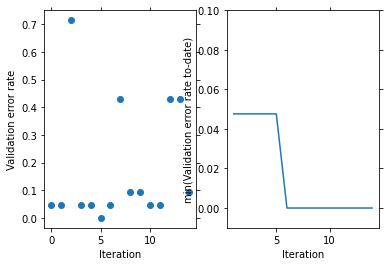

In [4]:
# Demo version of estimator.fit()
fit_iterator = estimator.fit_iter(X_train,y_train)
fit_iterator.__next__()
plot_helper = hpsklearn.demo_support.PlotHelper(estimator,
                                                mintodate_ylim=(-.01, .10))
while len(estimator.trials.trials) < estimator.max_evals:
    fit_iterator.send(1) # -- try one more model
    plot_helper.post_iter()
plot_helper.post_loop()

# -- Model selection was done on a subset of the training data.
# -- Now that we've picked a model, train on all training data.
estimator.retrain_best_model_on_full_data(X_train, y_train)

In [5]:
print('Best preprocessing pipeline:')
for pp in estimator._best_preprocs:
    print(pp)
print('\n')
print('Best classifier:\n', estimator._best_learner)
test_predictions = estimator.predict(X_test)
acc_in_percent = 100 * np.mean(test_predictions == y_test)
print('\n')
print('Prediction accuracy in generalization is %.1f%%' % acc_in_percent)

Best preprocessing pipeline:
MinMaxScaler(feature_range=(-1.0, 1.0))


Best classifier:
 ExtraTreesClassifier(bootstrap=True, criterion='entropy', max_depth=4,
                     max_features=0.8268757752512261, min_samples_leaf=7,
                     n_estimators=27, n_jobs=1, random_state=2, verbose=False)


Prediction accuracy in generalization is 97.8%
